# DJF_PR_teleconnection: Structure of Boreal Winter Precipitation Anomalies

The "DJF_PR_teleconnection" notebook evaluates the relationship between ENSO (El Niño-Southern Oscillation) and boreal winter precipitation anomalies, focusing on the region between 60°S and 60°N. It analyses the spatial and temporal structure of precipitation patterns during the DJF period, providing insights into teleconnections and their potential impacts on global climate variability.

## Recommended Observational Datasets

### Temperature Surface (TS)

- **ERSSTv5**: The Extended Reconstructed Sea Surface Temperature version 5 (ERSSTv5) is a global monthly sea surface temperature dataset derived from in situ observations and optimally interpolated. It is widely used for climate studies and trend analysis.

- **HadISSTv1.1**: The Hadley Centre Sea Ice and Sea Surface Temperature dataset version 1.1 (HadISSTv1.1) provides a globally complete dataset of monthly mean sea surface temperatures and sea ice concentrations since 1870.

- **COBE2**: The Centennial In Situ Observation-Based Estimates version 2 (COBE2) provides high-resolution sea surface temperature data, constructed using historical ship-based observations and modern quality control techniques.

## Precipitation (PR)

- **GPCP**: The Global Precipitation Climatology Project (GPCP) dataset combines satellite and ground-based observations to produce global monthly precipitation estimates with near-global coverage since 1979.

- **CMAP**: The CPC Merged Analysis of Precipitation (CMAP) integrates satellite and gauge-based observations to estimate global precipitation, providing valuable insights into climate variability and hydrological processes.

## Dask Cluster 
Start a cluster with multiple cores

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41573,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39195,Total threads: 3
Dashboard: /proxy/34673/status,Memory: 23.75 GiB
Nanny: tcp://127.0.0.1:43367,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_ts_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_pr_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}


obs_ts_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2)
}

obs_pr_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2)
}

## Add Ancillary files


In [4]:
for name, dataset in model_pr_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")
for name, dataset in model_ts_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_ts_datasets = {name: dataset.load() for name, dataset in model_ts_datasets.items()}
model_pr_datasets = {name: dataset.load() for name, dataset in model_pr_datasets.items()}

obs_ts_datasets = {name: dataset.load() for name, dataset in obs_ts_datasets.items()}
obs_pr_datasets = {name: dataset.load() for name, dataset in obs_pr_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


In [7]:
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino34_latext_region)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season="DJF")
    cube = seasonal_statistics(cube, operator="mean", seasons=("DJF","MAMJJASON"))
    
    return cube


def pr_global(cube):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_season(cube, season="DJF")
    cube = seasonal_statistics(cube, operator="mean", seasons=("DJF","MAMJJASON"))
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    
    return cube   

In [8]:
model_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in model_ts_datasets.items()}
model_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in model_pr_datasets.items()}

obs_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in obs_ts_datasets.items()}
obs_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in obs_pr_datasets.items()}

## Calculate Linear regression

In [9]:
def lin_regress_matrix(cubeA, cubeB):
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

In [10]:
reg2_mod = lin_regress_matrix(model_pr_datasets_prep["ACCESS-ESM1-5"], model_ts_datasets_prep["ACCESS-ESM1-5"])
reg2_obs = lin_regress_matrix(obs_pr_datasets_prep["GPCP-SG"], obs_ts_datasets_prep["HadISST"])

process = {"ACCESS-ESM1-5":reg2_mod , "HadISST":reg2_obs} 

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/scipy/linalg/_basic.py:1486: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [11]:
print(obs_pr_datasets_prep["GPCP-SG"].data.min(), obs_ts_datasets_prep["HadISST"].data.min())
print(model_pr_datasets_prep["ACCESS-ESM1-5"].data.min(), model_ts_datasets_prep["ACCESS-ESM1-5"].data.min())

-8.410527 -1.8005661
-15.509793 -2.2502296


In [12]:
#create shapely geometry from lat/lon..
from shapely import box
import numpy as np
import shapely.vectorized as shp_vect

def get_sea_mask(cube_0time):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = mask_landsea(cube_0time, mask_out="sea")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    return cube.data.mask
    
# Create a set of x,y points from the cube
def mask_pacific(cube, seamask):
    region = box(120.,-15.,290.,15) #remove land from mask?
    x_p, y_p = np.meshgrid(
        cube.coord(axis="X").points,
        cube.coord(axis="Y").points,
    )

    mask = shp_vect.contains(region, x_p, y_p)
    #add sea mask to include land in pacific
    mask = mask.astype(int) + seamask.astype(int)
    use_mask = np.zeros_like(mask, bool)
    use_mask[mask == 2] = True

    cube.data = np.ma.MaskedArray(cube.data, mask=use_mask)
    
    # cube.data.mask = use_mask
    return cube

In [13]:
# mask and compute 
obs_seamask = get_sea_mask(obs_pr_datasets["GPCP-SG"][0]) ##preproc?
mod_seamask = get_sea_mask(model_ts_datasets["ACCESS-ESM1-5"][0])
reg2_obs_masked = mask_pacific(reg2_obs, mod_seamask)

reg2_mod_masked = mask_pacific(reg2_mod, mod_seamask)

rmse = np.sqrt(np.mean((reg2_obs_masked.data- reg2_mod_masked.data) ** 2))
print(rmse)

process = {"ACCESS-ESM1-5":reg2_mod_masked , "Observation":reg2_obs_masked} 

0.3506313081449157


# Diagnostic Level 1

In [14]:
reg2_mod.data.min(), reg2_mod.data.max(), reg2_obs.data.min(), reg2_obs.data.max(), reg2_obs.data.mean()

(-2.8029394, 2.88494, -2.1295838, 1.1866268, -0.040333914005654406)

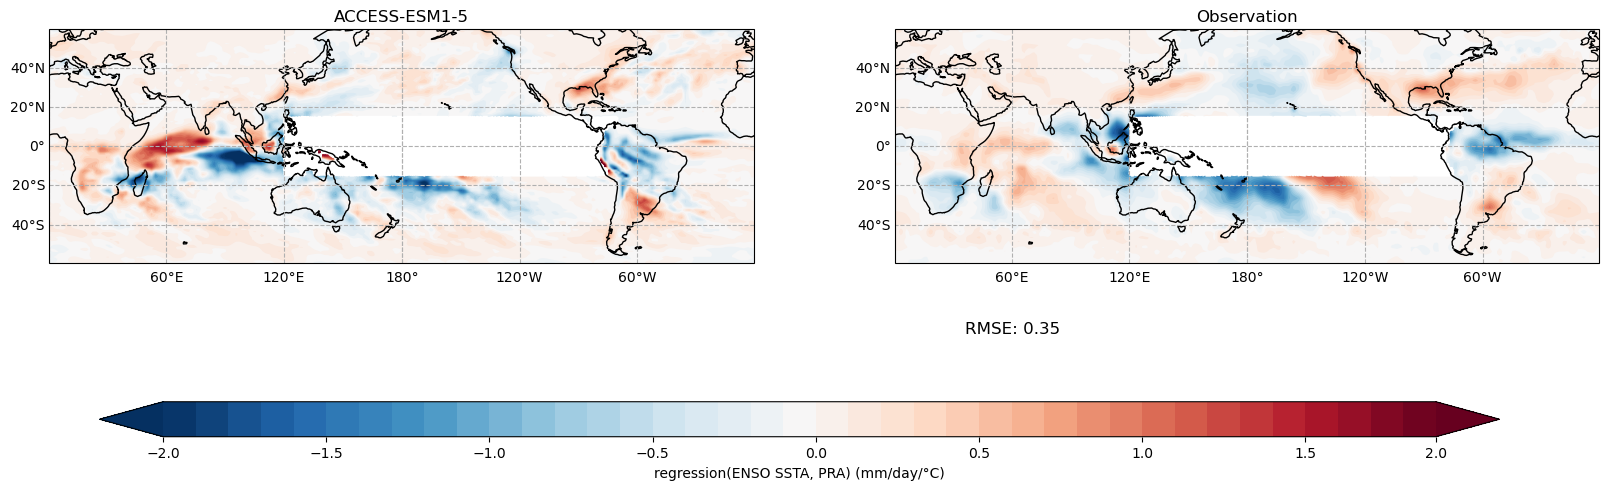

In [15]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.PlateCarree(central_longitude=180)

i =121

for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-2,2,0.1), extend='both', cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    i+=1

plt.text(0.1, -0.3, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-2,2.5,0.5))
cbar.set_label('regression(ENSO SSTA, PRA) (mm/day/°C)')

In [16]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean
from skimage.transform import resize

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [49]:
class Visualization():
    """
    A class to generate, process, and render visualizations of geospatial data using contour plots and Lavavu.

    This class supports generating RGBA images from geospatial data, applying resizing and padding,
    handling opacity layers, and displaying results in Lavavu either as a contour field or smoothed gradient.

    Attributes:
        data (iris.cube.Cube): Input geospatial data (2D).
        size (tuple): Desired image size as (width, height).
        lat_range (tuple): Latitude range to display (min_lat, max_lat).
        lon_range (tuple): Longitude range to display (min_lon, max_lon).
        title (str): Title of the visualization.
        colormap (str or callable): Colormap used for the visualization.
        tickvalues (list): Tick values to show on colorbar.
        vmax (float): Maximum value for normalization.
        vmin (float): Minimum value for normalization.
        resolution (tuple, optional): Output resolution of the Lavavu window. Default is (700, 700).

    Methods:
        generate_rgba(): Generate RGBA image from the input data using matplotlib.
        resize_rgba(rgba, width, height): Resize an RGBA image to given dimensions.
        pad_rgba(data, pad_width, pad_height, pad_depth=None, constant_values=255): Pad an RGBA or data array.
        opacity_rgba(padded_array, opacity_array): Apply opacity to the alpha channel of an RGBA image.
        generate_lv(): Set up and configure the Lavavu Earth visualization.
        calculate_pad(): Compute the padding sizes based on latitude and longitude ranges.
        visualise_contourf(window=False): Generate and display contour visualization in Lavavu.
        visualise_gradient(window=False): Generate and display a smoothed gradient visualization in Lavavu.
    """

    
    def __init__(self, data, size, lat_range, lon_range, title, colormap, tickvalues, vmax, vmin, resolution=(700, 700)):
        self.data = data
        self.size = size
        self.width = size[0]
        self.height = size[1]
        self.title = title
        self.colormap = colormap
        self.tickvalues = tickvalues
        self.lat_range = lat_range
        self.lon_range = lon_range
        self.resolution =  resolution
        self.vmax = vmax
        self.vmin = vmin

    def generate_rgba(self):
        data = self.data.data  # 2D numpy array
        lon = self.data.coord('longitude').points
        lat = self.data.coord('latitude').points
        
        lon2d, lat2d = np.meshgrid(lon, lat)
        
        cmap = self.colormap
        norm = mcolors.Normalize(vmin=self.vmin, vmax=self.vmax)
        
        fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
        cmap.set_bad(color=(0, 0, 0, 0))
        cf = ax.contourf(lon2d, lat2d, data, cmap=cmap, norm=norm, levels=np.arange(-2,2,0.1))
        ax.axis('off')
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
        fig.canvas.draw()
        rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        rgba = rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4)
    
        rgba = rgba[:, :, [1, 2, 3, 0]]
        plt.close(fig)
        
        return rgba

    def resize_rgba(self, rgba, width, height):
        #If the original image is of type uint8, it needs to be converted to float32 before resizing.
        rgba_float = rgba.astype(np.float32) / 255.0
    
        # Resize the image (while preserving the number of channels).
        rgba_resized = resize(rgba_float, (width, height, 4), preserve_range=True, anti_aliasing=True)
        
        # change back to uint8
        rgba_resized = np.clip(rgba_resized * 255, 0, 255).astype(np.uint8)
    
        return rgba_resized
        
    def pad_rgba(self, data, pad_width, pad_height, pad_depth=None, constant_values=255):
        if pad_depth:
            padded_rgba = np.pad(
                        data,
                        pad_width=(pad_width, pad_height, pad_depth),
                        mode='constant',
                        constant_values=constant_values 
            )
        else:
             padded_rgba = np.pad(
                        data,
                        pad_width=(pad_width, pad_height),  
                        mode='constant',
                        constant_values=constant_values  
            )
            
        return padded_rgba

    def normalise_array(self, values, minimum=None, maximum=None):
        """
        Normalize an array to the range [0,1]
    
        Parameters
        ----------
        values : numpy.ndarray
            Values to convert, numpy array
        minimum: number
            Use a fixed minimum bound, default is to use the data minimum
        maximum: number
            Use a fixed maximum bound, default is to use the data maximum
        """
    
        # Ignore nan when getting min/max
        if not minimum:
            minimum = np.nanmin(values)
        if not maximum:
            maximum = np.nanmax(values)
    
        # Normalise
        array = (values - minimum) / (maximum - minimum)
        # Clip out of [0,1] range - in case defined range is not the global minima/maxima
        array = np.clip(array, 0, 1)
    
        return array

    def opacity_rgba(self, padded_array, opacity_array):
        array = self.normalise_array(opacity_array)
        oarray = array
        oarray = np.nan_to_num(oarray)
        oarray = (oarray * 255).astype(np.uint8)
        padded_array[::, ::, 3] = oarray
        
        return padded_array

    def generate_lv(self):
        lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
        lv.rotation(15.0, -200.0, 0.0) #Rotate to Pacific
        lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
        lv.brightness_contrast_saturation(0.5, 0.5, 0.65)

        cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=self.tickvalues)
        cbar.colourmap(self.colormap, range=[self.vmin, self.vmax])
        lv.title(self.title)
        
        return lv

    def calculate_pad(self):
        self.pad_width = (int((self.lat_range[0]-(-90))*5/3), int((90-self.lat_range[1])*5/3))
        self.pad_height = (int(self.lon_range[0]*5/3), int((360 - self.lon_range[1])*5/3))

    def visualise_contourf(self, window=False, Alpha=0.7):
        self.calculate_pad()
        rgba=self.generate_rgba()
      
        resized_rgba=self.resize_rgba(rgba,width=self.width,height=self.height)
        opacity_array = resize(self.data.data, self.size, order=1, preserve_range=True, anti_aliasing=True)
        padded_rgba=self.pad_rgba(resized_rgba,pad_width=self.pad_width,pad_height=self.pad_height,pad_depth=(0, 0), constant_values=0)
        padded_rgba[:,:,3]=padded_rgba[:,:,3]*Alpha

        lv = self.generate_lv()
        accessvis.update_earth_values(lv, dataMode=0, data=padded_rgba)
        

        if window:
            lv.window(resolution=self.resolution)
        else:
            lv.display(resolution=self.resolution)

    def visualise_gradient(self, window=False):
        lv = self.generate_lv()

        pad_width = ((self.lat_range[0]-(-90)), (90-self.lat_range[1]))
        pad_height = (self.lon_range[0], (360 - self.lon_range[1]))

        padded_data = np.pad(self.data.data, pad_width=(pad_width, pad_height), mode='constant', constant_values=0)

        smoothed = gaussian_filter(padded_data, sigma=1.0)
        colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=self.colormap, opacitymap=True, minimum=self.vmin, maximum=self.vmax)
        accessvis.update_earth_values(lv, dataMode=0, data=colours_model)
        if window:
            lv.window(resolution=self.resolution)
        else:
            lv.display(resolution=self.resolution)

In [50]:
obs_data = process["Observation"]
model_data = process["ACCESS-ESM1-5"]

v_model = Visualization(data=model_data, size=(200,600), lat_range=(-60, 60), lon_range=(0, 360), title="ACCESS-ESM1-5", colormap=plt.get_cmap('RdBu_r'), tickvalues=np.arange(-2,2.5,0.5), vmax=2, vmin=-2)
v_obs = Visualization(data=obs_data, size=(200,600), lat_range=(-60, 60), lon_range=(0, 360), title="Observation", colormap=plt.get_cmap('RdBu_r'), tickvalues=np.arange(-2,2.5,0.5), vmax=2, vmin=-2)


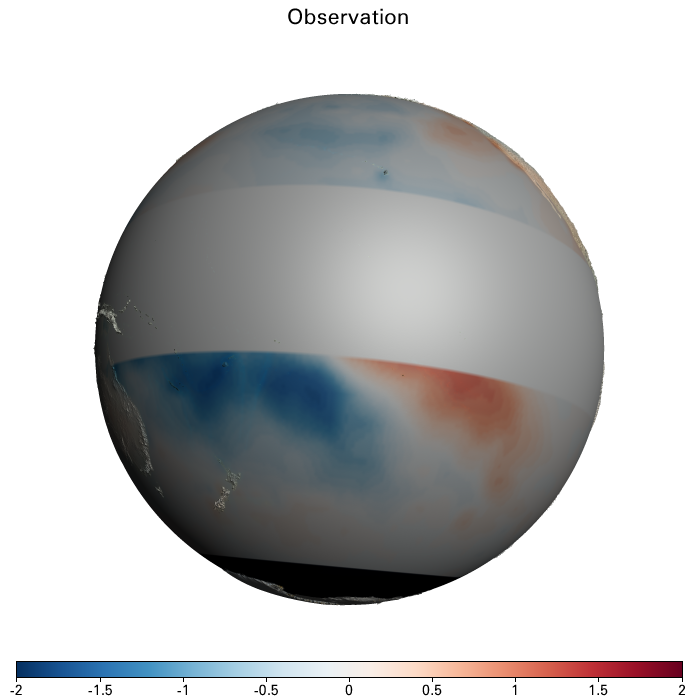

In [53]:
# specify window=True if you would like to open an interactive window
v_obs.visualise_contourf(window=False)


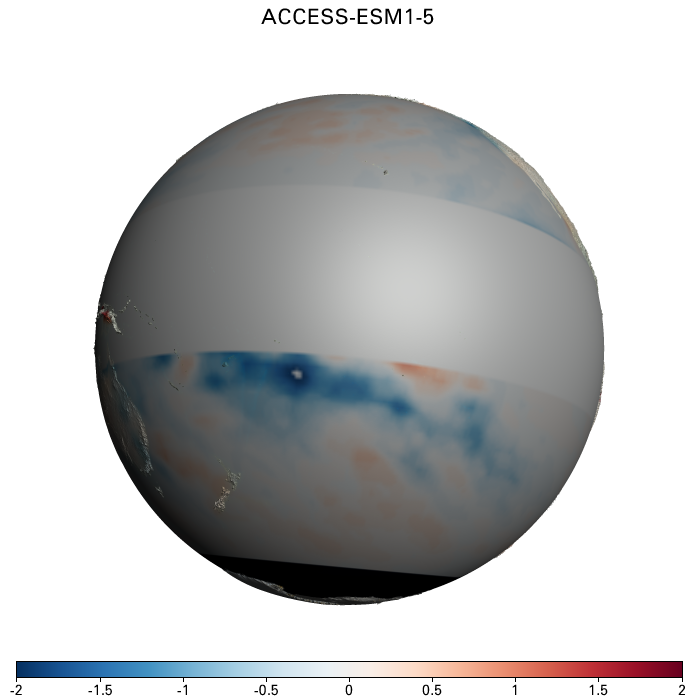

ERROR:aiohttp.server:Error handling request from ::1
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/aiohttp/web_protocol.py", line 510, in _handle_request
    resp = await request_handler(request)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/aiohttp/web_app.py", line 569, in _handle
    return await handler(request)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/lavavu/aserver.py", line 107, in handle_get
    lv = _get_viewer(request.app['viewer'])
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/lavavu/aserver.py", line 26, in _get_viewer
    raise(Exception("Viewer not found"))
Exception: Viewer not found


In [54]:
# specify window=True if you would like to open an interactive window
v_model.visualise_contourf(window=False)

## Diagnostics level 2 
el nino, la nina, PRA mm/day

In [29]:
from esmvalcore.preprocessor import mask_above_threshold
from esmvalcore.preprocessor import mask_below_threshold
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_time
import numpy as np

def nino3_4ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    # triangle weighted- double smoothed
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube, 'mean')
    cube = extract_month(cube, 12)
    cube = anomalies(cube, period='monthly')  
    #divide std?
    return cube
    
def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]
    
def enso_events(cube):
    std = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75 * std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75 * std))
    return {'nina':a_events, 'nino':o_events}

In [30]:
prep_datasets = {"ACCESS-ESM1-5":[model_pr_datasets_prep["ACCESS-ESM1-5"],model_ts_datasets_prep["ACCESS-ESM1-5"]],
                    'HadISST':[obs_pr_datasets_prep["GPCP-SG"],obs_ts_datasets_prep["HadISST"]]}
ts_datasets = {**model_ts_datasets, **obs_ts_datasets}

In [31]:

events_dict = {}
for name, ds in ts_datasets.items(): #ts
    nino_res = nino3_4ssta(ds)
    events_dict[name] = enso_events(nino_res)

cubes_dict_nina = {} #collect cubes, dataset(obs,model), enso(nina.nino) - apply to ts and pr preproc
cubes_dict_nino = {}
for ds_name, events in events_dict.items():
    print(ds_name)
    for enso, years in events.items():
        # cube pr and cube ts
        print(enso, len(years), 'number of event years')
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in years)
        cube_pr = prep_datasets[ds_name][0].extract(year_enso) # extract from pr cube
        cube_ts = prep_datasets[ds_name][1].extract(year_enso)
        
        if enso == 'nina': ## plot separate
            cubes_dict_nina[ds_name] = [cube_pr, cube_ts]
        else:
            cubes_dict_nino[ds_name] = [cube_pr, cube_ts]

print(events_dict)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


ACCESS-ESM1-5
nina 9 number of event years
nino 10 number of event years
HadISST
nina 7 number of event years
nino 9 number of event years
{'ACCESS-ESM1-5': {'nina': [1981, 1984, 1985, 1987, 1990, 1993, 1994, 1999, 2006], 'nino': [1983, 1995, 1997, 1998, 2001, 2004, 2008, 2010, 2012, 2013]}, 'HadISST': {'nina': [1984, 1988, 1998, 1999, 2007, 2010, 2011], 'nino': [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2006, 2009]}}


In [32]:
process = {} # mask..

for key, cubes in cubes_dict_nina.items():
    reg_cube = lin_regress_matrix(cubes[0], cubes[1])
    if key == 'HadISST':
        key = 'GPCP-SG-HadISST'
    process[f'{key} la nina DJF'] = mask_pacific(reg_cube, mod_seamask)
#rmse ..in plotting.. when even
for key, cubes in cubes_dict_nino.items():
    reg_cube = lin_regress_matrix(cubes[0], cubes[1])
    if key == 'HadISST':
        key = 'GPCP-SG-HadISST'
    process[f'{key} el nino DJF'] = mask_pacific(reg_cube, mod_seamask)

# print(np.sqrt(np.mean((process['obs'].data - process['ACCESS-ESM1-5'].data) ** 2)))

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

/jobfs/143817951.gadi-pbs/ipykernel_2524873/3088687036.py:24: UserWarning: Adding colorbar to a different Figure <Figure size 2000x700 with 2 Axes> than <Figure size 2000x800 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,1.8,0.5))


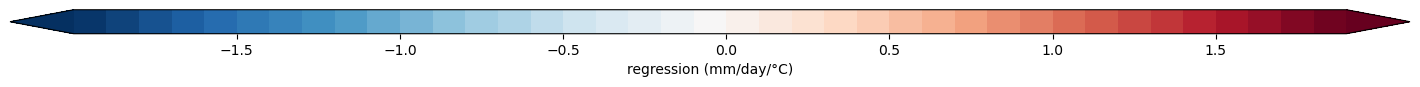

In [33]:
fig = plt.figure(figsize=(20, 8)) #func? params - process, rmse
proj = ccrs.PlateCarree(central_longitude=180)

i =221
for label, cube in process.items(): #j for 2 rows 
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1.5,1.5,0.1), extend='both', cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    
    if i%2 == 0: #model first, odd, prev
        rmse = np.sqrt(np.mean((cube.data- cube_prev.data) ** 2))
        plt.text(0.1, 0.95, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    i+=1
    cube_prev = cube
    

cax = plt.axes([0.15,0.01,0.7,0.03])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,1.8,0.5))
cbar.set_label('regression (mm/day/°C)')